<a href="https://colab.research.google.com/github/Upadala/Car-Prices-Prediction/blob/main/car_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np


In [ ]:
# Load data
df = pd.read_csv("car_prices.csv")
# Basic info
print("Head:\n", df.head())
print("Info:\n", df.info())
print("Describe:\n", df.describe())

Head:
    year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  inc  20500.0       21500.0   
1                 kia motor

In [ ]:
print(df.head())

   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  inc  20500.0       21500.0   
1                 kia motors ameri

In [ ]:
# Feature engineering
df["age"] = 2025 - df["year"]
df["mileage_per_year"] = df["odometer"] / df["age"].replace(0, 1)
luxury_brands = ["BMW", "Mercedes", "Audi", "Lexus"]
df["is_luxury"] = df["make"].isin(luxury_brands).astype(int)

# Handle missing values
df["condition"] = df["condition"].fillna(df["condition"].median())
df["odometer"] = df["odometer"].fillna(df["odometer"].median())
df["transmission"] = df["transmission"].fillna(df["transmission"].mode()[0])
for col in ["make", "model", "trim", "body", "color", "interior"]:
    df[col] = df[col].fillna(df[col].mode()[0])

# Handle outliers (cap odometer and sellingprice)
df["odometer"] = df["odometer"].clip(upper=df["odometer"].quantile(0.99))
df["sellingprice"] = df["sellingprice"].clip(upper=df["sellingprice"].quantile(0.99))

In [ ]:
# Parse saledate
df["saledate"] = pd.to_datetime(df["saledate"], errors="coerce", format="%a %b %d %Y %H:%M:%S GMT%z")
df["sale_year"] = df["saledate"].dt.year
df["sale_month"] = df["saledate"].dt.month
# Handle outliers (based on your output: odometer max 999,999, sellingprice min 1)
print("Extreme odometers:", df[df["odometer"] > 500000].shape)

Extreme odometers: (0, 21)


In [ ]:
df = df[df["odometer"] <= 500000]
df = df[df["sellingprice"] >= 100]  # Remove unrealistic prices

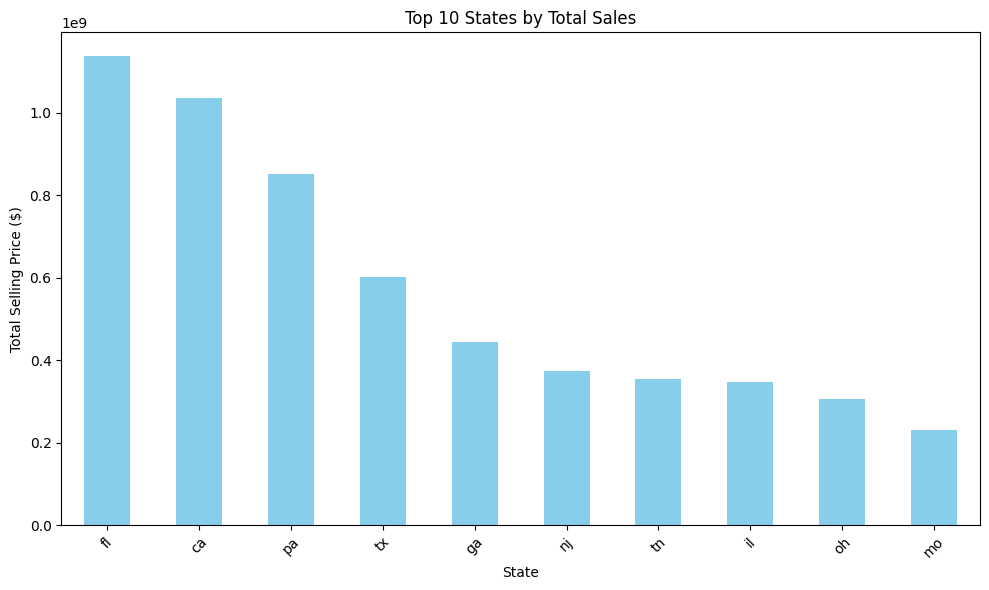

In [ ]:
# Trends for dashboard
# Plot 1: Sales by State (Bar Chart)
state_sales = df.groupby("state")["sellingprice"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
state_sales.plot(kind="bar", color="skyblue")
plt.title("Top 10 States by Total Sales")
plt.xlabel("State")
plt.ylabel("Total Selling Price ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

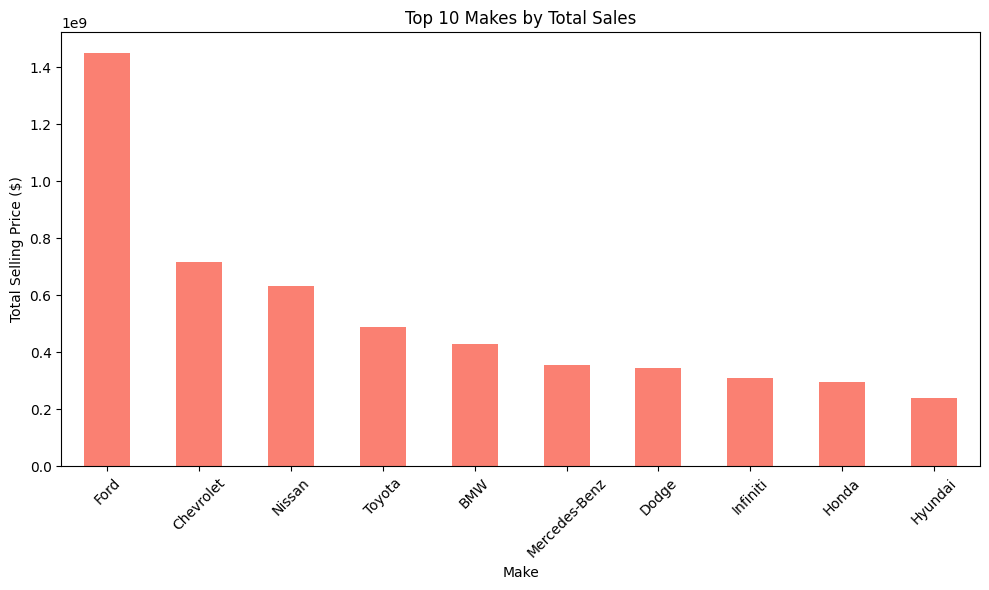

In [ ]:
# Plot 2: Sales by Make (Bar Chart)
top_makes = df.groupby("make")["sellingprice"].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_makes.plot(kind="bar", color="salmon")
plt.title("Top 10 Makes by Total Sales")
plt.xlabel("Make")
plt.ylabel("Total Selling Price ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

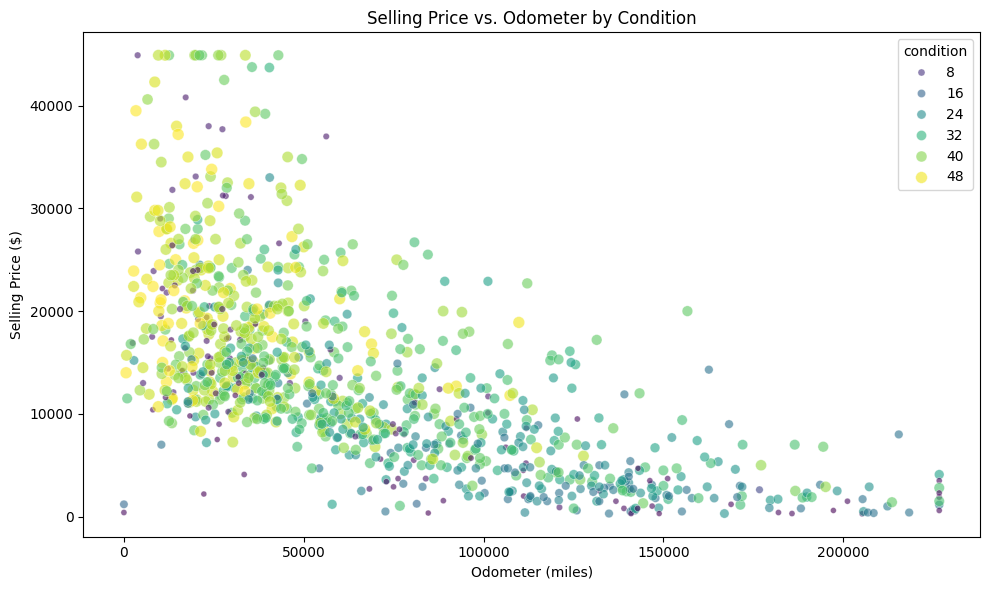

In [ ]:
# Plot 3: Selling Price vs. Odometer (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(x="odometer", y="sellingprice", hue="condition", size="condition",
                data=df.sample(1000, random_state=42), palette="viridis", alpha=0.6)
plt.title("Selling Price vs. Odometer by Condition")
plt.xlabel("Odometer (miles)")
plt.ylabel("Selling Price ($)")
plt.tight_layout()
plt.show()
# Save cleaned data for ML and dashboard
df.to_csv("sales_cleaned.csv", index=False)

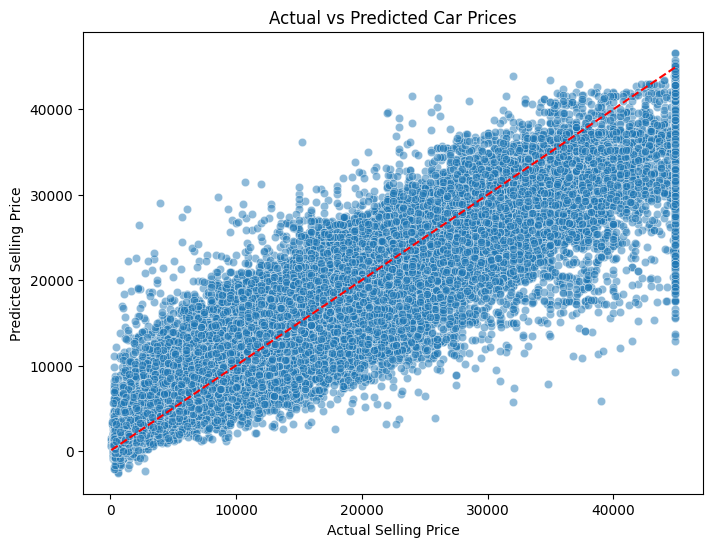

XGBoost - R² Score: 0.863, MAE: 2225.05, RMSE: 3355.30
Predicted price for the new car: $41279.01


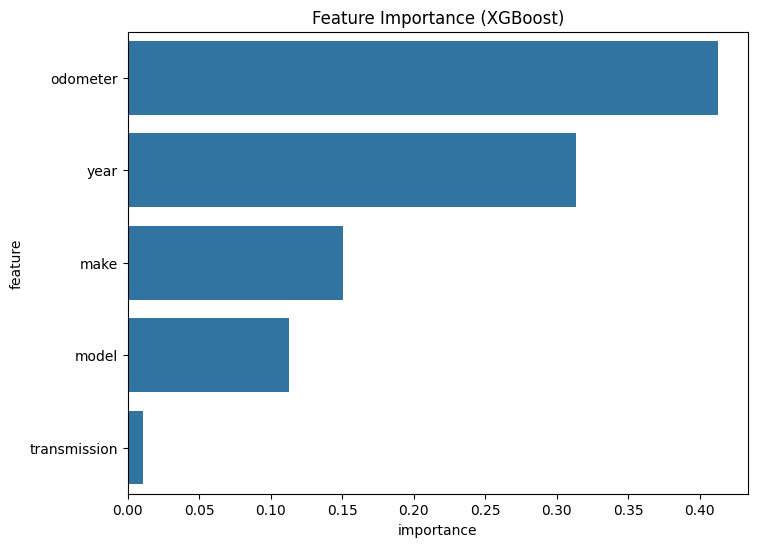

In [ ]:
def main():
    file_path = "car_prices.csv"
    df = load_data(file_path)
    if df is None:
        return
    df = feature_engineering(df)
    # Define categorical features for this simplified prediction
    categorical_features = ['make', 'model', 'transmission']
    X_train, X_test, y_train, y_test, le_dict = prepare_data_for_modeling(df, categorical_features)
    # Train and Evaluate XGBoost model
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    trained_model, r2, mae, rmse = train_and_evaluate_model(X_train, y_train, X_test, y_test, xgb_model, model_name="XGBoost")


    # Prediction for new car
    new_car_data = {
        'year': 2022,
        'make': 'BMW',
        'model': 'X5',
        'odometer': 25000,
        'transmission': 'automatic',
    }
    new_car_df = pd.DataFrame([new_car_data])
    new_car_df = feature_engineering(new_car_df)
    new_car_df = new_car_df[['year', 'make', 'model', 'odometer', 'transmission']]

    for col, le in le_dict.items():
        if col in new_car_df.columns:
            new_car_df[col] = le.transform(new_car_df[col].astype(str))
    new_car_df = new_car_df[X_train.columns]
    predicted_price = trained_model.predict(new_car_df)
    print(f"Predicted price for the new car: ${predicted_price[0]:.2f}")
#Feature Importance
    importances = trained_model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)
    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=importance_df)
    plt.title('Feature Importance (XGBoost)')
    plt.show()

#Predicted vs Actual Price Plot
y_pred = trained_model.predict(X_test)

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')  # ideal line
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Car Prices')
plt.show()

if __name__ == "__main__":
    main()




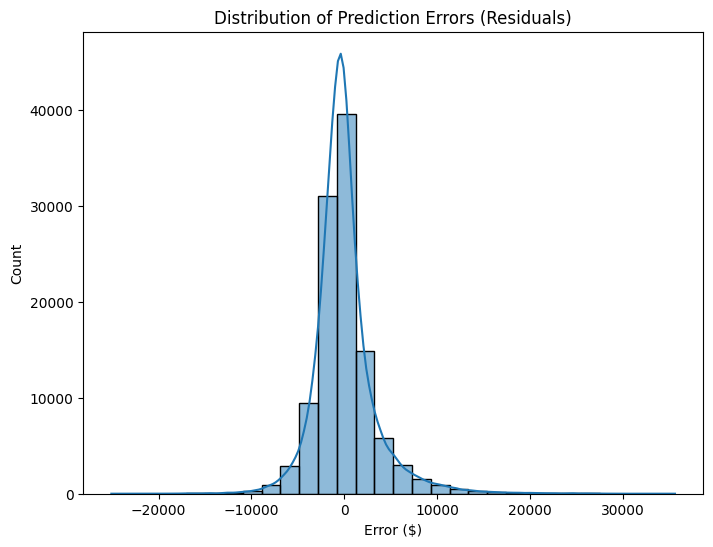

In [ ]:
#Residual Plots
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Distribution of Prediction Errors (Residuals)')
plt.xlabel('Error ($)')
plt.show()



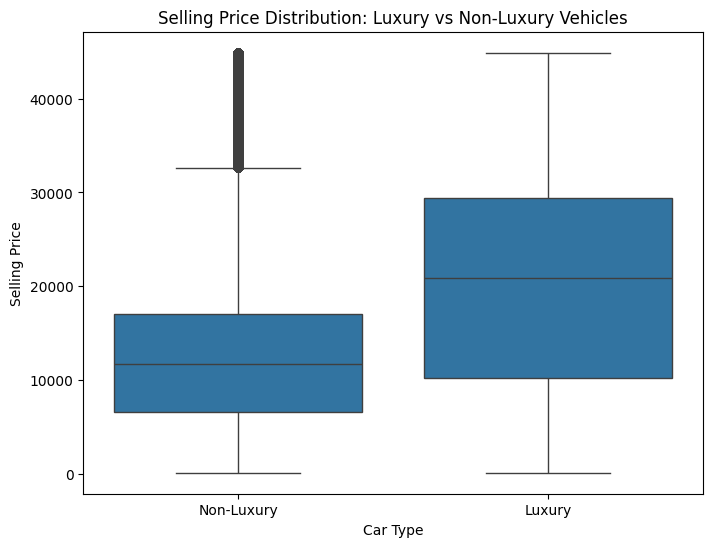

In [ ]:
luxury_brands = ['BMW', 'Audi', 'Mercedes-Benz', 'Lexus', 'Porsche', 'Jaguar', 'Land Rover']

df['is_luxury'] = df['make'].apply(lambda x: 1 if x in luxury_brands else 0)
plt.figure(figsize=(8,6))
sns.boxplot(x='is_luxury', y='sellingprice', data=df)
plt.xticks([0,1], ['Non-Luxury', 'Luxury'])
plt.title('Selling Price Distribution: Luxury vs Non-Luxury Vehicles')
plt.xlabel('Car Type')
plt.ylabel('Selling Price')
plt.show()
